In [ ]:
import pandas as pd

file_path = "openalex_results_with_topics.csv"

df = pd.read_csv(file_path)

In [4]:
print(df.iloc[0]["best_oa_location"])

nan


In [6]:
new_df = df.dropna(subset=['best_oa_location'])
print(new_df.iloc[0]["best_oa_location"])

{"is_oa": true, "landing_page_url": "https://publications.rwth-aachen.de/record/207126", "pdf_url": "http://www-i6.informatik.rwth-aachen.de/publications/downloader.php?id=820&row=pdf", "source": {"id": "https://openalex.org/S4306401362", "display_name": "RWTH Publications (RWTH Aachen)", "issn_l": null, "issn": null, "is_oa": true, "is_in_doaj": false, "is_indexed_in_scopus": false, "is_core": false, "host_organization": "https://openalex.org/I887968799", "host_organization_name": "RWTH Aachen University", "host_organization_lineage": ["https://openalex.org/I887968799"], "host_organization_lineage_names": ["RWTH Aachen University"], "type": "repository"}, "license": "other-oa", "license_id": "https://openalex.org/licenses/other-oa", "version": "publishedVersion", "is_accepted": true, "is_published": true}


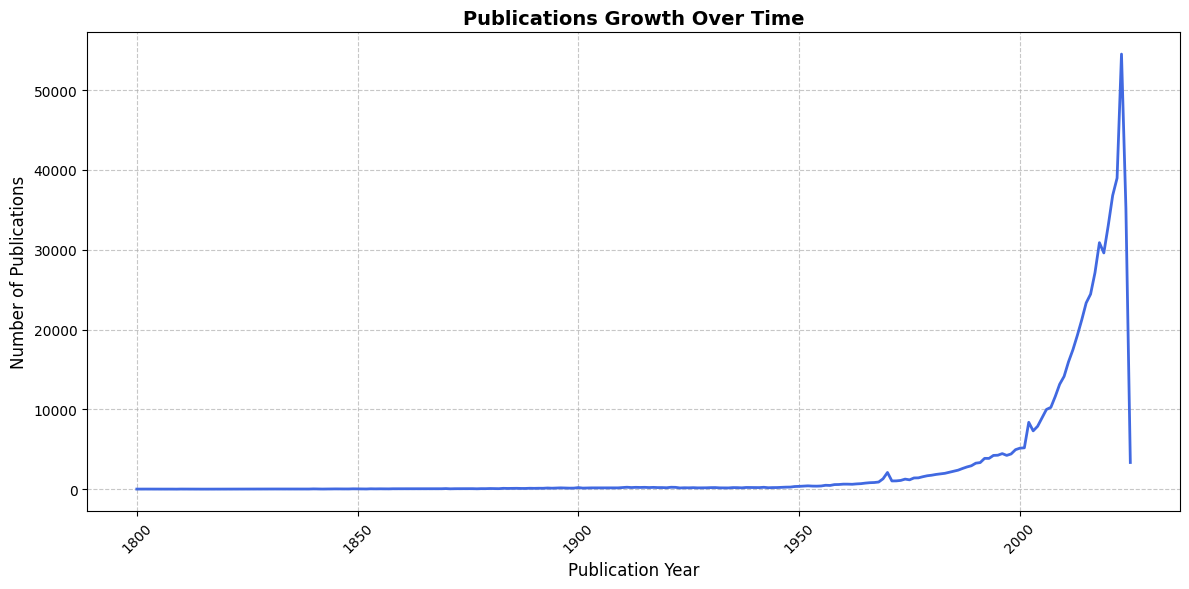

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

if 'publication_year' in df.columns:
    df['publication_year'] = pd.to_numeric(df['publication_year'], errors='coerce')

    df_year = df.dropna(subset=['publication_year'])
    df_year = df_year[df_year['publication_year'] >= 1800] 
    
    year_counts = df_year['publication_year'].value_counts().sort_index()

    year_counts.index = year_counts.index.astype(int)

    full_index = np.arange(year_counts.index.min(), year_counts.index.max() + 1)
    smoothed_counts = year_counts.reindex(full_index, fill_value=np.nan).astype(float).interpolate()

    plt.figure(figsize=(12, 6))
    plt.plot(smoothed_counts.index, smoothed_counts.values, color='royalblue', linewidth=2)

    plt.title("Publications Growth Over Time", fontsize=14, fontweight="bold")
    plt.xlabel("Publication Year", fontsize=12)
    plt.ylabel("Number of Publications", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    plt.savefig("Publications_Growth_Over_Time.png")
    plt.show()


In [ ]:
import ast

def reconstruct_abstract(inverted_index):
    try:
        inverted_dict = ast.literal_eval(inverted_index)
        positions = []
        for word, pos_list in inverted_dict.items():
            for pos in pos_list:
                positions.append((pos, word))
        positions.sort(key=lambda x: x[0])
        abstract_text = " ".join([p[1] for p in positions])
        return abstract_text
    except:
        return ""

df['text_abstract'] = df['abstract_inverted_index'].astype(str).apply(reconstruct_abstract)

In [ ]:
def extract_topics(topics):
    topic_names = []

    if isinstance(topics, str):  
        topics = ast.literal_eval(topics)
    
    if isinstance(topics, list):
        for topic in topics:
            if isinstance(topic, str):
                topic = ast.literal_eval(topic)
            
            if isinstance(topic, dict) and "field" in topic:
                domain_names.append(topic["display_name"])

    return list(set(domain_names)) 

df["extracted_topics"] = df.apply(lambda row: extract_topics(row["topics"]), axis=1)

In [ ]:
def extract_domains(topics):
    domain_names = []

    if isinstance(topics, str):  
        topics = ast.literal_eval(topics)
    
    if isinstance(topics, list):
        for topic in topics:
            if isinstance(topic, str):
                topic = ast.literal_eval(topic)
            
            if isinstance(topic, dict) and "field" in topic and "display_name" in topic["field"]:
                domain_names.append(topic["field"]["display_name"])

    return list(set(domain_names)) 

df["extracted_domains"] = df.apply(lambda row: extract_domains(row["topics"]), axis=1)

df.to_csv("documents_full_data.csv", index=False)


In [37]:
all_domains = []
if 'extracted_domains' in df.columns:
    for domain_list in df['extracted_domains'].dropna():
        all_domains.extend(domain_list)

num_unique_domains = len(set(all_domains))
print("Number of unique domains in 'domain' column:", num_unique_domains)

all_topics = []
if 'extracted_topics' in df.columns:
    for topic_list in df['extracted_topics'].dropna():
        all_topics.extend(topic_list)

num_unique_topics = len(set(all_topics))
print("Number of unique topics in 'topics' column:", num_unique_topics)

Number of unique domains in 'domain' column: 26
Number of unique topics in 'topics' column: 4547


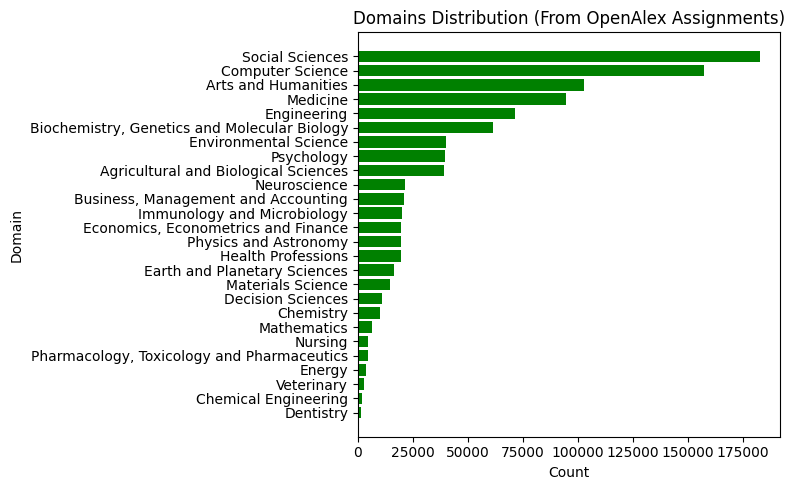

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

if 'extracted_domains' in df.columns:
    df['extracted_domains'] = df['extracted_domains'].apply(
        lambda x: list(set(eval(x))) if isinstance(x, str) else list(set(x))
    )

    df_exploded = df.explode('extracted_domains')

    domain_counts = Counter(df_exploded['extracted_domains'].dropna())  
    top_10_domains = domain_counts.most_common(26) 

    domain_df = pd.DataFrame(top_10_domains, columns=['Domain', 'Count'])

    plt.figure(figsize=(8, 5))
    plt.barh(domain_df['Domain'], domain_df['Count'], color='green')
    plt.gca().invert_yaxis() 
    plt.title("Domains Distribution (From OpenAlex Assignments)")
    plt.xlabel("Count")
    plt.ylabel("Domain")
    plt.tight_layout()
    plt.savefig("Domains_Distribution.png")
    plt.show()

In [ ]:
df.to_csv("openalex_results_with_topics_1.csv")

In [ ]:
import pandas as pd

df = pd.read_csv("openalex_results_with_topics_1.csv")

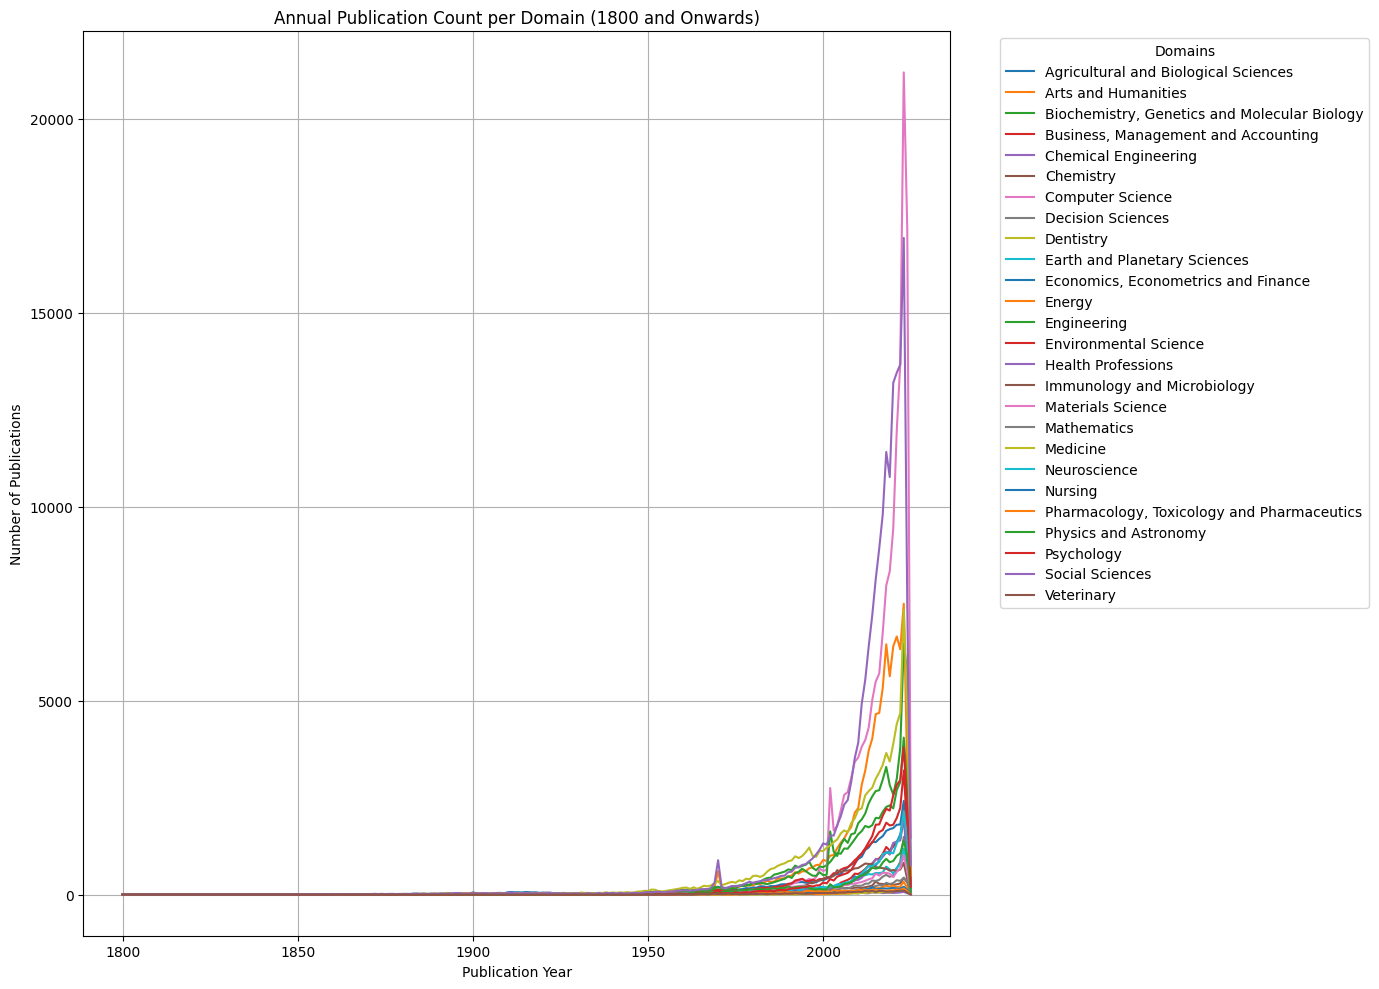

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

df['publication_year'] = pd.to_numeric(df['publication_year'], errors='coerce').astype('Int64')

df = df.dropna(subset=['publication_year', 'extracted_domains'])

df = df[df['publication_year'] >= 1800]

def safe_literal_eval(val):
    if isinstance(val, str):
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            return val  
    return val 

df['extracted_domains'] = df['extracted_domains'].apply(safe_literal_eval)

df['extracted_domains'] = df['extracted_domains'].apply(lambda x: x if isinstance(x, list) else [x])

df_exploded = df.explode('extracted_domains')

domain_yearly_counts = df_exploded.groupby(['publication_year', 'extracted_domains']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 10))
for domain in domain_yearly_counts.columns:
    plt.plot(domain_yearly_counts.index, domain_yearly_counts[domain], label=domain)
plt.xlabel('Publication Year')
plt.ylabel('Number of Publications')
plt.title('Annual Publication Count per Domain (1800 and Onwards)')
plt.legend(title='Domains', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('domain_popularity_over_time.png')
plt.show()


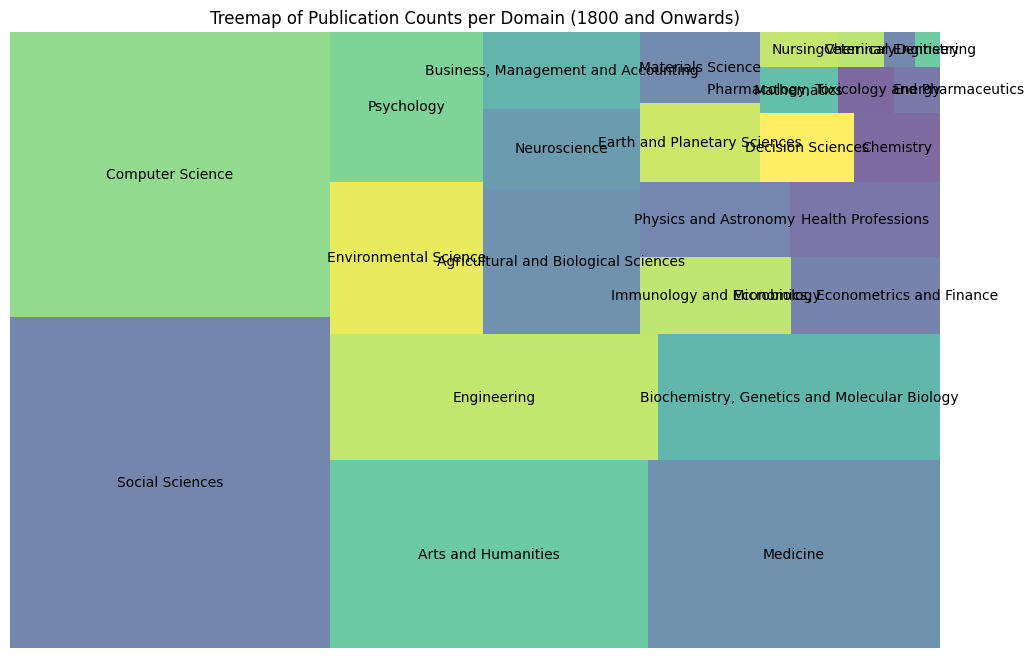

In [9]:
! pip install squarify

import matplotlib.pyplot as plt
import squarify

domain_counts = df_exploded['extracted_domains'].value_counts()

plt.figure(figsize=(12, 8))
squarify.plot(sizes=domain_counts.values, label=domain_counts.index, alpha=0.7)

plt.title("Treemap of Publication Counts per Domain (1800 and Onwards)")
plt.axis("off")  

plt.show()


In [14]:
print(df.columns)

Index(['Unnamed: 0', 'id', 'display_name', 'doi', 'title', 'publication_year',
       'publication_date', 'topics', 'primary_topic', 'keywords',
       'cited_by_count', 'related_works', 'concepts',
       'abstract_inverted_index', 'best_oa_location', 'text_abstract',
       'extracted_topics', 'extracted_concepts', 'extracted_domains'],
      dtype='object')


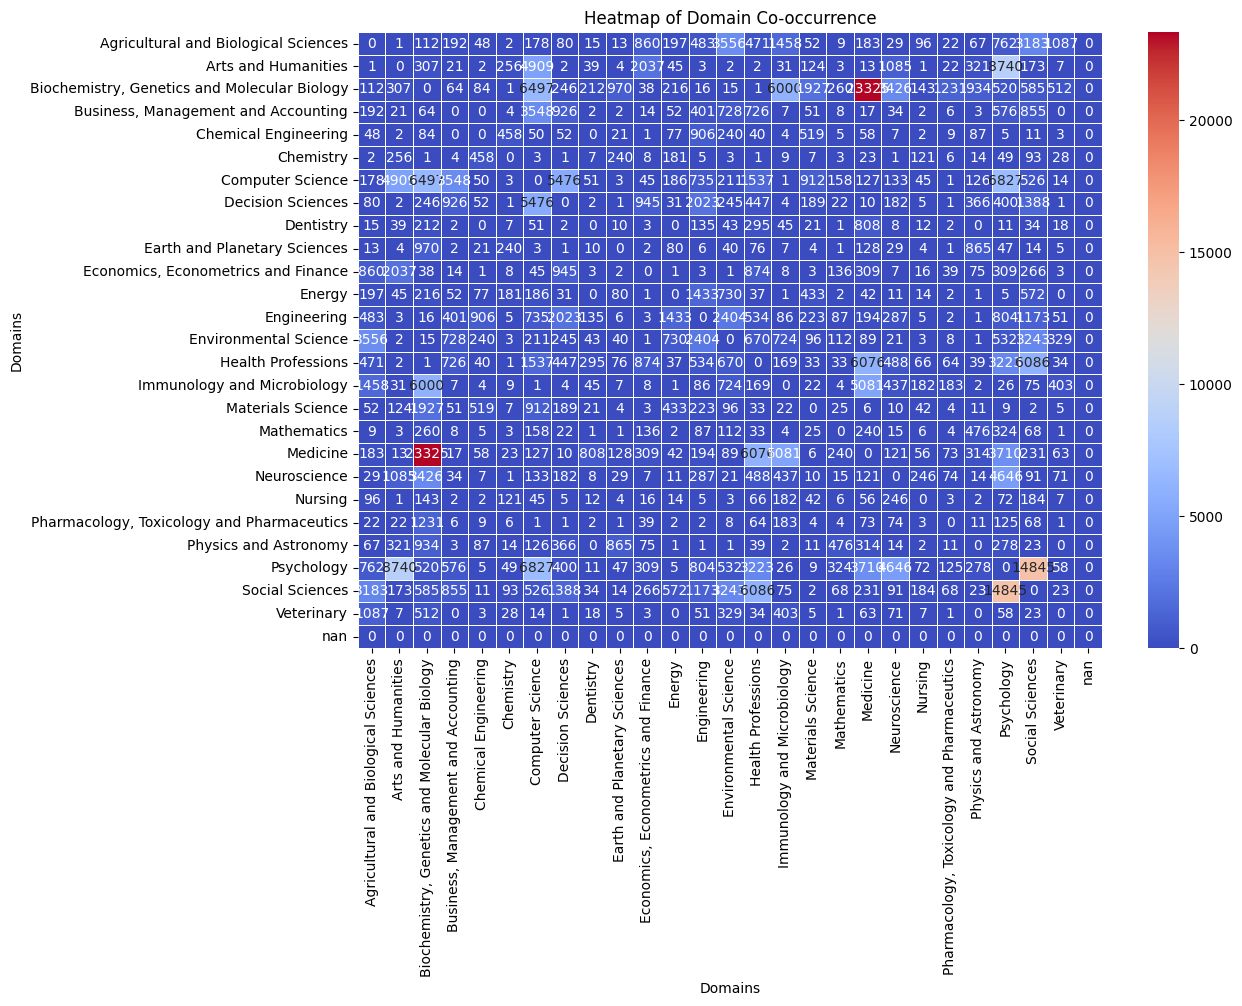

<Figure size 640x480 with 0 Axes>

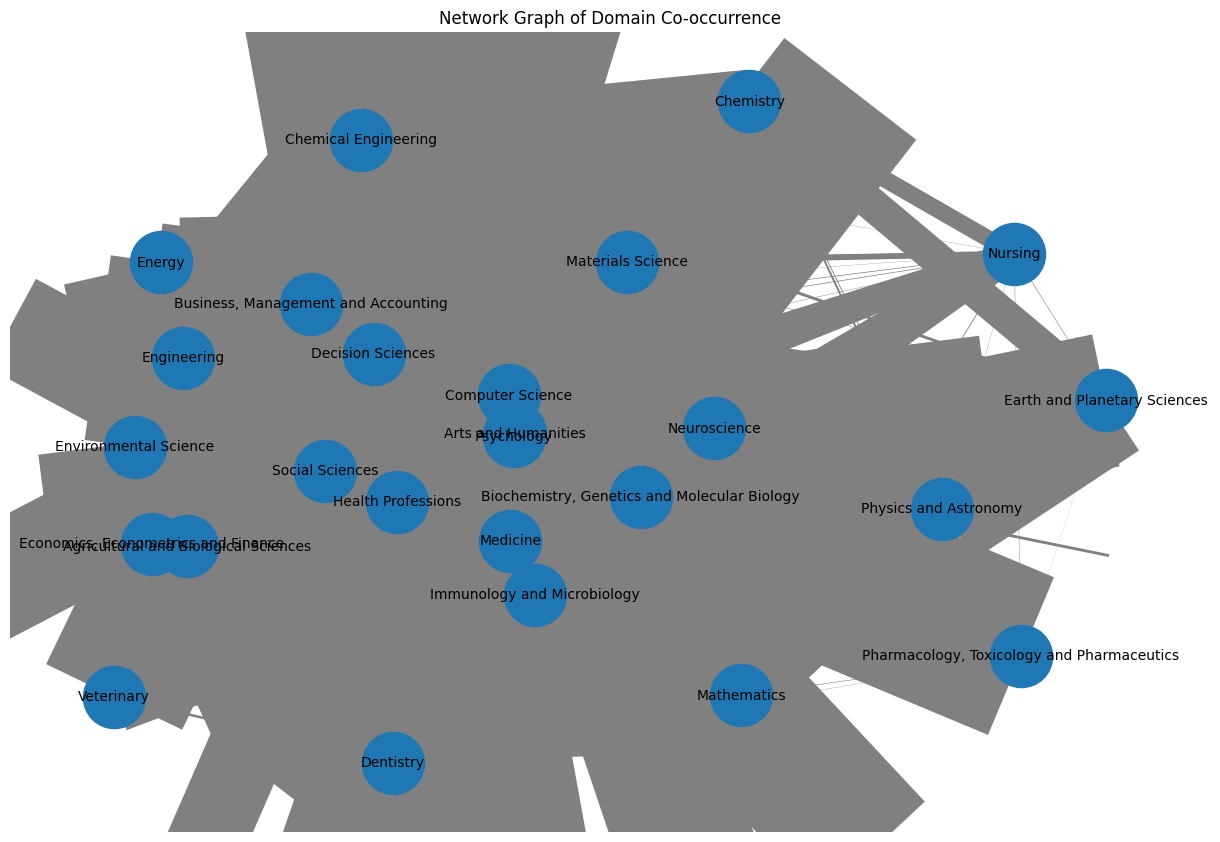

<Figure size 640x480 with 0 Axes>

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import ast
from itertools import combinations
from collections import Counter

def safe_literal_eval(val):
    if isinstance(val, str):
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            return val  
    return val  

df['extracted_domains'] = df['extracted_domains'].apply(safe_literal_eval)
df['extracted_domains'] = df['extracted_domains'].apply(lambda x: x if isinstance(x, list) else [x])

df = df.dropna(subset=['extracted_domains'])

df_exploded = df.explode('extracted_domains')

df_exploded['extracted_domains'] = df_exploded['extracted_domains'].astype(str)

cooccurrence_pairs = []
for domains in df['extracted_domains']:
    cooccurrence_pairs.extend(combinations(domains, 2))  

cooccurrence_counts = Counter(cooccurrence_pairs)

unique_domains = sorted(set(df_exploded['extracted_domains']))  
cooccurrence_matrix = pd.DataFrame(0, index=unique_domains, columns=unique_domains)

for (domain1, domain2), count in cooccurrence_counts.items():
    cooccurrence_matrix.at[domain1, domain2] = count
    cooccurrence_matrix.at[domain2, domain1] = count 

plt.figure(figsize=(12, 8))
sns.heatmap(cooccurrence_matrix, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap of Domain Co-occurrence")
plt.xlabel("Domains")
plt.ylabel("Domains")
plt.show()
plt.savefig('Heatmap_of_Domain_Co-occurrence.png')


G = nx.Graph()

for (domain1, domain2), weight in cooccurrence_counts.items():
    if weight > 0:  
        G.add_edge(domain1, domain2, weight=weight)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42) 
edges = G.edges(data=True)

nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10, edge_color="gray", width=[d["weight"] * 0.1 for _, _, d in edges])
plt.title("Network Graph of Domain Co-occurrence")
plt.show()
plt.savefig("Network_Graph_of_Domain_Co-occurrence.png")

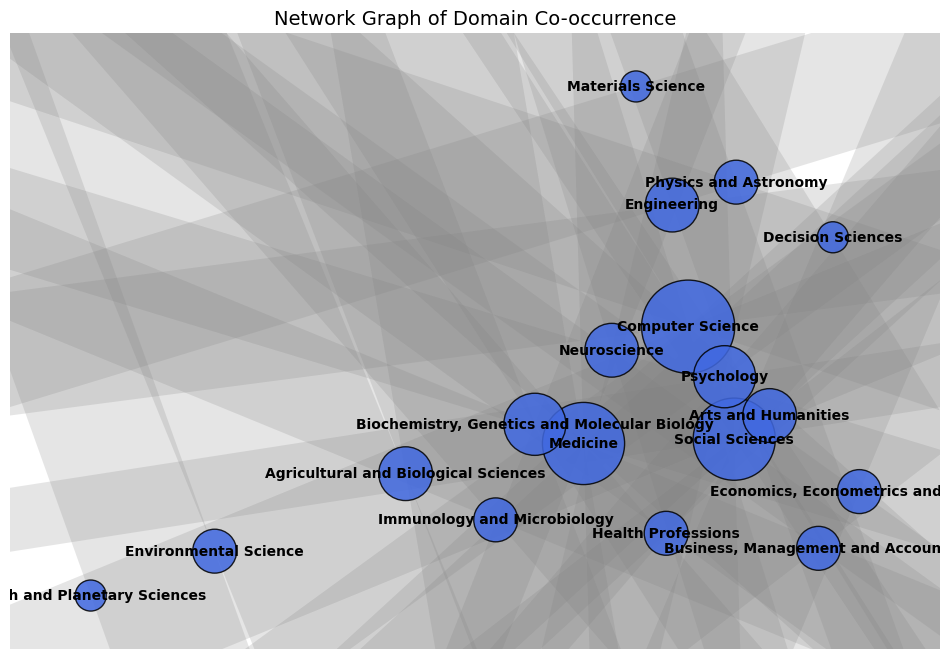

<Figure size 640x480 with 0 Axes>

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

top_edges = sorted(cooccurrence_counts.items(), key=lambda x: x[1], reverse=True)[:30]

for (domain1, domain2), weight in top_edges:
    G.add_edge(domain1, domain2, weight=weight)

node_sizes = [G.degree(n) * 500 for n in G.nodes()] 

edge_weights = [G[u][v]['weight'] * 0.5 for u, v in G.edges()]

pos = nx.spring_layout(G, seed=42, k=0.7)  

plt.figure(figsize=(12, 8))
nx.draw_networkx_edges(G, pos, alpha=0.2, width=edge_weights, edge_color="gray", style="dashed") 
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="royalblue", alpha=0.85, edgecolors="black")  
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold", font_color="black")  

plt.title("Network Graph of Domain Co-occurrence", fontsize=14)
plt.axis("off")  
plt.show()
plt.savefig("Network_Graph_of_Domain_Co-occurrence.png")

In [7]:
import networkx as nx

G = nx.Graph()

top_edges = sorted(cooccurrence_counts.items(), key=lambda x: x[1], reverse=True)[:30]

for (domain1, domain2), weight in top_edges:
    G.add_edge(domain1, domain2, weight=weight)

graphml_file = "domain_cooccurrence.graphml"
nx.write_graphml(G, graphml_file)

print(f"Graph successfully exported to {graphml_file}. You can import it into Cytoscape!")


Graph successfully exported to domain_cooccurrence.graphml. You can import it into Cytoscape!


In [8]:
! pip install sentence-transformers

In [4]:
def combine_text(title, abstract):
    if pd.isna(title):
        title = ""
    if pd.isna(abstract):
        abstract = ""
    return f"{title} {abstract}"

df['paper_text'] = df.apply(
    lambda row: combine_text(row.get('title', ''), row.get('text_abstract', '')),
    axis=1
)

# Remove rows that have no text at all
df = df[df['paper_text'].str.strip().str.len() > 0].reset_index(drop=True)

In [5]:
print(f"Number of papers after filtering: {len(df)}")

Number of papers after filtering: 616732


In [ ]:
import pandas as pd

file_path = "documents_full_data.csv"

df = pd.read_csv(file_path)

In [7]:
import numpy as np
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

sampled_df = df.sample(n=100000, random_state=42)

print(len(sampled_df))

# Convert paper text into embeddings (one vector per paper)
# This step can take a while if your dataset is large.
embeddings = model.encode(sampled_df['paper_text'].tolist(), 
                          show_progress_bar=True, 
                          convert_to_numpy=True, 
                          batch_size=32)

print(f"Embedding shape: {embeddings.shape}")
np.save("embeddings.npy", embeddings)
# loaded_embeddings = np.load("embeddings.npy")
print("Finished Saving Embeddings.")

100000


Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

Embedding shape: (100000, 384)
Finished Saving Embeddings.


In [12]:
sampled_df.to_csv("/dt/puzis/autonet/Neta/Miki_Project/sampled_df.csv")

In [ ]:
import pandas as pd

papers_file_path = "documents_full_data.csv"
institutions_file_path = "openalex_institutions_results.csv"

papers_df = pd.read_csv(papers_file_path)
institutions_df = pd.read_csv(institutions_file_path)

/tmp/ipykernel_907113/3528361723.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  institutions_df = pd.read_csv(institutions_file_path)


In [7]:
papers_df = papers_df.dropna(subset=['best_oa_location'])

In [8]:
import json

id_to_country = dict(zip(institutions_df["id"], institutions_df["country_code"]))

def get_country_code_fast(metadata_json):
    try:
        if isinstance(metadata_json, str):
            metadata = json.loads(metadata_json)
        elif isinstance(metadata_json, dict):
            metadata = metadata_json
        else:
            return None
        
        source = metadata.get("source", {})
        if not isinstance(source, dict):
            return None

        source_id = source.get("id")
        host_org = source.get("host_organization")

        return id_to_country.get(source_id) or id_to_country.get(host_org)

    except json.JSONDecodeError:
        return None
    except Exception as e:
        print(f"Error processing metadata: {e}")
        return None

papers_df["country_code"] = papers_df["best_oa_location"].map(get_country_code_fast)

print(papers_df.head())


                                  id  \
3   https://openalex.org/W2402268235   
10  https://openalex.org/W4246858749   
12  https://openalex.org/W1527575280   
15  https://openalex.org/W2259472270   
18  https://openalex.org/W2567070169   

                                         display_name  \
3          LSTM neural networks for language modeling   
10                    Relevance based language models   
12  Unifying Visual-Semantic Embeddings with Multi...   
15          Exploring the Limits of Language Modeling   
18  Language Modeling with Gated Convolutional Net...   

                                             doi  \
3   https://doi.org/10.21437/interspeech.2012-65   
10         https://doi.org/10.1145/383952.383972   
12      https://doi.org/10.48550/arxiv.1411.2539   
15     https://doi.org/10.48550/arxiv.1602.02410   
18     https://doi.org/10.48550/arxiv.1612.08083   

                                                title  publication_year  \
3          LSTM neural netwo

In [21]:
! pip install geodatasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 886.9 kB/s eta 0:00:000:00:01


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def interactive_academic_papers_map(df, world_gdf, domain_col='extracted_domains', country_col='country_code', cmap='OrRd'):
    """
    Create an interactive world map with a dropdown to switch between domains.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing academic papers data.
    world_gdf : geopandas.GeoDataFrame
        World GeoDataFrame.
    domain_col : str, default 'extracted_domains'
        Column containing a list of domains for each paper.
    country_col : str, default 'country_code'
        Column containing the country code for each paper.
    cmap : str, default 'OrRd'
        Colormap for the heatmap.

    Returns:
    --------
    None
        Displays the interactive map.
    """
    df = df.copy()
    df[domain_col] = df[domain_col].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith("[") else x)

    df_exploded = df.explode(domain_col)
    
    unique_domains = sorted(df_exploded[domain_col].dropna().unique())

    iso_column ='ISO_A2'
    
    domain_dropdown = widgets.Dropdown(
        options=unique_domains,
        description='Select Domain:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='300px')
    )

    output = widgets.Output()

    def update_map(change):
        with output:
            output.clear_output(wait=True)
            
            selected_domain = change['new']
            
            df_domain = df_exploded[df_exploded[domain_col] == selected_domain]

            country_counts = df_domain[country_col].value_counts().reset_index()
            country_counts.columns = ['iso_alpha', 'paper_count']

            merged_data = world_gdf.merge(country_counts, left_on=iso_column, right_on='iso_alpha', how='left')
            merged_data['paper_count'] = merged_data['paper_count'].fillna(0)


            fig, ax = plt.subplots(figsize=(12, 8))
            merged_data.plot(column='paper_count', ax=ax, legend=True, cmap=cmap, 
                             missing_kwds={"color": "lightgrey"}, 
                             legend_kwds={'label': 'Number of Papers', 'orientation': 'horizontal'})
            
            ax.set_title(f"Academic Papers Distribution for {selected_domain}", fontsize=15)
            ax.set_axis_off()

            plt.show()

    domain_dropdown.observe(update_map, names='value')

    display(domain_dropdown, output)

    update_map({'new': unique_domains[0]})




world = gpd.read_file("/110m_cultural/ne_110m_admin_0_countries.shp")

interactive_academic_papers_map(papers_df, world)


Dropdown(description='Select Domain:', layout=Layout(width='300px'), options=('Agricultural and Biological Sci…

Output()